# Credit Card Fraud Detection

<a id="contents"></a>
### Contents
#### 1. [Introduction](#intro)<br></br>
#### 2. [Data Preprocessing](#preprocessing)<br></br>
#### 3. [Training](#training)<br></br>
#### 4. [Handling the Imbalance](#imbalance)<br></br>
#### 5. [Model Evaluation](#evaluation)<br></br>
#### 6. [Conclusions](#conclusions)<br></br>


<a id="intro"></a>
## Introduction

Credit card fraud is the unauthorized use of a credit or debit card or a similar payment tool, to fraudulently obtain money or property.
In 2018, money lost from fraud involving credit cards worldwide reached $27.85 billion.
It is important that credit card companies are able to detect and decline fraudulent credit card transactions so that their customers are not wrongly charged.
This aim of this project is to create a model to detect such fraudulent transactions using data from previous transactions, gotten from [Credit Card Fraud Detection | Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).

## Dataset Description

The Dataset contains transactions made in September 2013 by European cardholders.
It presents transactions that occurred in two days. It contains 284,807 instances, each representing a transaction. It contains 30 features. Features V1, V2, ... , V28 are the principal components obtained with PCA; the only features which have not been transformed with PCA are 'Time' and 'Amount'. This also served to anonymize the dataset to protect sensitive information. It contains only numerical input variables which are the result of a PCA transformation. 

| Column | Type | Description |
| --- | :---: |:--- |
| Time | continuous | seconds elapsed between each transaction and the first transaction in the dataset |
| V1 | continuous | principal components obtained with PCA |
| V2 | continuous | principal components obtained with PCA |
| V3 | continuous | principal components obtained with PCA |
| V4 | continuous | principal components obtained with PCA |
| ... | ... | ... |
| V26 | continuous | principal components obtained with PCA |
| V27 | continuous | principal components obtained with PCA |
| V28 | continuous | principal components obtained with PCA |
| Amount | continuous | transaction amount |
| Class | continuous | response variable, 1 for fraud and 0 otherwise |

In [41]:
import numpy as np
import pandas as pd
import gzip
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef,  plot_confusion_matrix
import pickle

sns.set()

In [42]:
def read_csv(fn):
    with gzip.open(fn, "rt", newline='', encoding="UTF-8") as file:
        return pd.read_csv(file)

DATA_CACHE = None

def get_data():
    global DATA_CACHE
    if DATA_CACHE is None:
        DATA_CACHE = read_csv("creditcard.csv.gz")
    return DATA_CACHE

In [43]:
data = get_data()

In [44]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


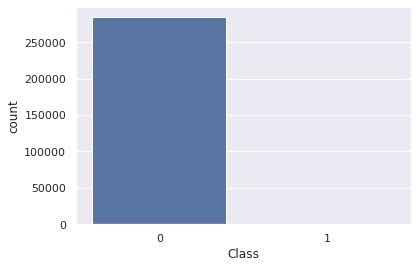

In [45]:
sns.countplot(x = data.Class)

<a id="preprocessing"></a>
## Data Preprocessing
The entire dataset was caled using standard scaler.
The scaled dataset was then split into train and test sets.
The train set was further split into training and validation sets. <br>
[Back to Contents](#contents)

In [46]:
#Some helper fuctions, for training, testing and evaluating.
def evalscore(actual, predictions):
    """
    Calculates the following Metrics: precision score, recall_score and f1 score.
    
    args:
        actual: the actual values of the label.
        predictions: the predictions made by the model.
        
    returns: a list of the metric scores [precision score, 'recall_score', 'f1_score', 'mcc']  
    """
    temp = [precision_score(actual, predictions), recall_score(actual, predictions), f1_score(actual, predictions), matthews_corrcoef(actual, predictions)]
    return temp


def compareModels(models, xtrain, ytrain, xtest, ytest):
    """
    Trains each model in models using xtrain and ytrain and evaluates on xtest and ytest.
    It creates a dataframe showing the comparison.
    
    args:
        models: a list of models to compare.
        xtrain, ytrain: the features and labels for training.
        xtest, ytest: the features and labels for evaluation.
    
    returns: tuple[trained_models, dataframe]
            trained_models: a list of the trained models, dataframe: a dataframe showing the comparisons
    """
    trained = {}
    dt = {}
    for model in models:
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        dt[models[model]] = evalscore(ytest, preds)
        trained[model] = models[model]
    return trained, pd.DataFrame(dt, index = ['precision score', 'recall_score', 'f1_score', 'mcc'])

    
def compareModelsCV(models, x, y):
    """
    Trains each model in models using and the models are validated using KFold cross validation.
    It creates a dataframe showing the comparison.
    
    args:
        models: a list of models to compare.
        xtrain, ytrain: the features and labels for training.
        xtest, ytest: the features and labels for evaluation.
    
    returns: tuple[trained_models, dataframe]
            trained_models: a list of the trained models, dataframe: a dataframe showing the comparisons
    """
    trained = {}
    dt = {}
    kf = KFold(n_splits = 5, shuffle = True)
    for model in models:
        scores = []
        for tr, te in kf.split(x):
            xtrain, xtest, ytrain, ytest = x[tr], x[te], y[tr], y[te]
            model.fit(xtrain, ytrain)
            preds = model.predict(xtest)
            scores.append(evalscore(ytest, preds))   
        dt[models[model]] = np.array(scores).mean(axis = 0)
        trained[model] = models[model]
    return trained, pd.DataFrame(dt, index = ['precision score', 'recall_score', 'f1_score', 'mcc'])

def evalModels(models, x, actual):
    """Testing function"""
    dt = {}
    for model in models:
        preds = model.predict(x)
        dt[models[model]] = evalscore(actual, preds)
    return pd.DataFrame(dt, index = ['precision score', 'recall_score', 'f1_score', 'mcc'])


In [47]:
traindata, evaldata = train_test_split(data, test_size = 0.33, random_state = 97, stratify = data.Class)
print("Traindata shape: {}\nEvaldata shape: {}".format(traindata.shape, evaldata.shape))

Traindata shape: (190820, 31)
Evaldata shape: (93987, 31)


In [48]:
print("Traindata:\n{}\n\nEvaldata:\n{}".format(traindata.Class.value_counts(), evaldata.Class.value_counts()))

Traindata:
0    190490
1       330
Name: Class, dtype: int64

Evaldata:
0    93825
1      162
Name: Class, dtype: int64


In [49]:
X, y = traindata.drop('Class', axis = 1), traindata.Class

In [16]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data = pd.DataFrame(scaled_data, columns = X.columns)
fx, fy = scaled_data, y

<a id="training"></a>
## Training
The models are trained using KFold cross validation.
Support Vector Machine, Random Forest and XGBoost were used to create base models.</br>
The f1 score was used to determine the best model and the precision score, matthew's correlation coefficient and recall score were used as reference.
[Back to Contents](#contents)

In [50]:
svm = SVC()
rf = RandomForestClassifier()
xgb = XGBClassifier()
models = {svm: 'SVM', rf: "Random Forest", xgb: "XGBoost"}

In [ ]:
trained_modelsB, summaryB = compareModelsCV(models, scaled_data.values, y.values)
summaryB

,SVM,Random Forest,XGBoost
precision score,0.941698,0.928307,0.922332
recall_score,0.635864,0.769390,0.777927
f1_score,0.757828,0.840373,0.843467
mcc,0.772820,0.844362,0.846554


<a id="imbalance"></a>
## Handling the imbalance
Oversampling and undersampling techniques are applied to reduce imbalance.<br>
SMOTE is used to oversample the positive cases and RandomUnderSampler is used to undersample the negative cases.
[Back to Contents](#contents)

In [ ]:
overs = SMOTE(sampling_strategy = 0.5)
unders = RandomUnderSampler(sampling_strategy = 0.5)
steps = [("over", overs), ("under", unders)]
pipe = Pipeline(steps = steps)
X, y = pipe.fit_resample(X, y)

In [52]:
scaler = StandardScaler()
hiscaled_data = scaler.fit_transform(X)
hiscaled_data = pd.DataFrame(hiscaled_data, columns = traindata.columns.drop("Class"))
hx, hy = hiscaled_data, y

In [ ]:
trained_modelsI, summaryI = compareModelsCV(models, hiscaled_data.values, y)
summaryI

,SVM,Random Forest,XGBoost
precision score,0.997548,0.999581,0.994909
recall_score,0.990127,0.999874,0.976414
f1_score,0.993823,0.999727,0.985574
mcc,0.990769,0.999591,0.978560


### Training with full data
The best model based on the f1_score from the cross validation was used to train the entire train set.
The XGBoost model with the imabalanced data and the RandomForest model with the balanced data gave the best results upon cross validation with the train set.

In [17]:
final_model = XGBClassifier()
final_model.fit(fx, fy)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
final_model2 = RandomForestClassifier()
final_model2.fit(hx, hy)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<a id="evaluation"></a>
## Model Evaluation
The evaluation metric chosen was the f1 score, using the precision score, matthew's correlation coefficient and recall score as reference. This was chosen because we want our model to predict the positive cases as correctly as possible. <br>
[Back to Contents](#contents)

In [21]:
scaled_test = scaler.fit_transform(evaldata.drop("Class", axis = 1))
scaled_test = pd.DataFrame(scaled_test, columns = evaldata.drop("Class", axis= 1).columns)

In [22]:
y_test = evaldata.Class
y_test.value_counts()

0    93825
1      162
Name: Class, dtype: int64

In [25]:
fdict = {final_model: "XGBoost", final_model2: "RandomForest"}
evalModels(fdict, scaled_test, y_test)

,XGBoost,RandomForest
precision score,0.933333,0.008348
recall_score,0.777778,0.691358
f1_score,0.848485,0.016497
mcc,0.851785,0.065168


Text(0.5, 1.0, 'RandomForest')

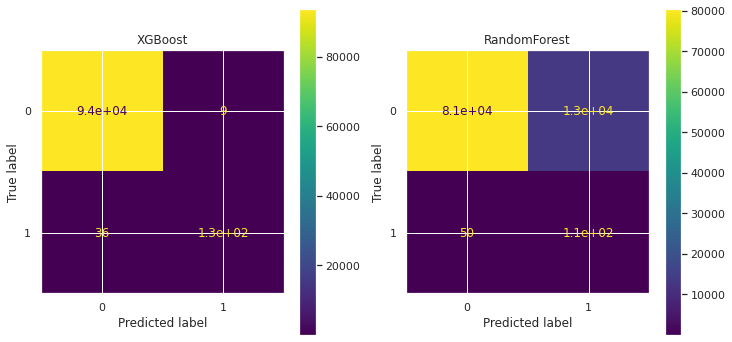

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axes.ravel()
plot_confusion_matrix(final_model, scaled_test, y_test, ax = ax1)
plot_confusion_matrix(final_model2, scaled_test, y_test, ax = ax2)
ax1.set_title("XGBoost")
ax2.set_title("RandomForest")

The results show that even though the balanced dataset performed very well with the train set, it's performance on new data is poor based on the prediction of positive cases.<br></br>
On the other hand, the XGBoost model that was trained with the imbalanced data performed well with a precision score of 93% and an f1 score of 85%. Of the 162 cases, it predicted 135 positive cases of which 126 are correct.

<a id="conclusions"></a>
## Conclusions
This project was aimed at reducing credit card fraud by detecting fraudulent transactions. Using the historic data we have been able to create a machine learning model that can predict such fraudulent transactions. The deployment of this model is dependent on the features in the dataset which were anonymized to protect sensitive data, so only the owners of the data that have these features would be able to deploy this model in practice.
In addition, if the features were not anonymized, it might have given some more insights into the data that would have helped to improve performance.
     
[Back to top](#contents)